# This notebook contains the final regression analysis code

It follows from the data generated in the notebook called "Prepare_WESE_analysisData"

In [13]:
## Load libraries
libs<-c("ggplot2","plyr","dplyr","jsonlite","plot3D","caret","plotROC","lmtest")
lapply(libs, require, character.only = TRUE)
pathToLocalGit<-"~/Workspace/WESE/ContinentalWESEestimates/"

## Load the source utility functions file
source(file=paste0(pathToLocalGit,"scripts/fitRegressionModels_functions.R"))

#load the data
load(file="~/Workspace/WESE/ContinentalWESEestimates/data/WESEdata_forContinentalAnalyses.RData")

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

### Here are the covariates to use in the models.
Use linear and quadratic forms for the numerics, and combinations between numerics and factors. Quadratics must be added to the equation as so: I(distToShore^2). Combining numerics and factors means a slope of the numeric for each level of the factor.   
   
Numeric:   
  * scaledmeanslope   
  * logmeanbathy  
  * logglacierdist  
  * logdistToShore  
  * logcont300dist  
  * logcont800dist  
  * logdistNearestIceEdge  
  * logfastIceWidth  
  * logempedist  
  * logadpedist  
  * logADPEabund  
  * logEMPEabund  
  * fastIceRatio  
  * Persistence2Years (3 levels: 0, 1, 2)  
  * PredictabilityDec5Years (6 levels: 0, 1,...,5)
  * Persistence3Years (4 levels: 0, 1, 2, 3)  
  * PredictabilityOct5Years (6 levels: 0, 1,...,5)
  
Factors:  
  * DecemberIcePresence (0/1)    
  * InCanyon (0/1)  
  * InTrough (0/1)  
  * Region - reference: Ross Sea
  * adpepresent (yes/no)
  * empepresent (yes/no)

In [14]:
#THIS IS THE "FULL" MODEL as per convo July 6 US-time
fml<-paste0("presence~scaledmeanslope+I(scaledmeanslope^2)+logmeanbathy+adpepresent*logadpedist+empepresent*logempedist+",
            "I(logempedist^2)+I(logadpedist^2)+logEMPEabund+logADPEabund*Region+Region*PredictabilityOct5Years+",
            "logdistToShore+I(logdistToShore^2)+Region*logcont300dist+InCanyon+",
            "Region*fastIceRatio+Region*logglacierdist")
reslst<-fitModelToBootstrap(fml=fml,datalist=bootsamp,fam="binomial")
## Note: not indicating the family so it defaults to "gaussian" and fits a simple regression

In [15]:
gofres<-summarizeResults(fitobj=reslst,what="gof")
print(gofres)

                  Parameter     Value Nboot
Df                       Df  2885.000   100
AIC                     AIC  2956.328   100
LogLik               LogLik -1439.164   100
ResidDeviance ResidDeviance  2878.328   100


Let's examine the results, starting with a summary of the coefficients. For this we use the function "summarizeResults". The function has two arguments: the fitobj is the object resulting from using the fitModelToBootstrap function above (in our example, fitobj is reslst), and the "what" parameter. This parameter has three possible values: "coefs", "gof", or "resids". The latter is the vector of average residuals. Let's look at the coefficients and the goodness-of-fit results.

In [16]:
coefres<-summarizeResults(fitobj=reslst,what="coefs")
row.names(coefres)<-NULL
print(coefres)

                                Parameter Coefficient StError z_value Prob_t
1                             (Intercept)      91.625  14.321   6.386  0.000
2                         scaledmeanslope       0.337   0.154   2.199  0.071
3                    I(scaledmeanslope^2)      -0.079   0.035  -2.278  0.068
4                            logmeanbathy       0.261   0.083   3.119  0.013
5                           adpepresentno     -17.469   4.071  -4.291  0.001
6                             logadpedist       2.721   0.973   2.806  0.020
7                           empepresentno      11.751   3.637   3.174  0.016
8                             logempedist     -12.317   1.571  -7.804  0.000
9                        I(logempedist^2)       0.559   0.075   7.463  0.000
10                       I(logadpedist^2)      -0.166   0.053  -3.156  0.009
11                           logEMPEabund      -0.140   0.047  -2.956  0.013
12                           logADPEabund      -0.024   0.047  -0.503  0.522

## Evaluating goodness of fit
Here we calculate the confusion matrix statistics from all the bootstrap results combined, and plot the ROC curve with all the bootstrap results combined

,bootstrap,predicted,residual,observed
,<int>,<dbl>,<dbl>,<dbl>
1,1,0.1213897,-1.138161,0
2,1,0.2304915,-1.299531,0
3,1,0.2461203,-1.326472,0
4,1,0.4522252,-1.825568,0
5,1,0.2934868,-1.415402,0
6,1,0.1025082,-1.114216,0


Confusion Matrix and Statistics

          Reference
Prediction      A      P
         A 111745  36666
         P  34455 109534
                                          
               Accuracy : 0.7568          
                 95% CI : (0.7552, 0.7583)
    No Information Rate : 0.5             
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5135          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.7492          
            Specificity : 0.7643          
         Pos Pred Value : 0.7607          
         Neg Pred Value : 0.7529          
             Prevalence : 0.5000          
         Detection Rate : 0.3746          
   Detection Prevalence : 0.4924          
      Balanced Accuracy : 0.7568          
                                          
       'Positive' Class : P               
            

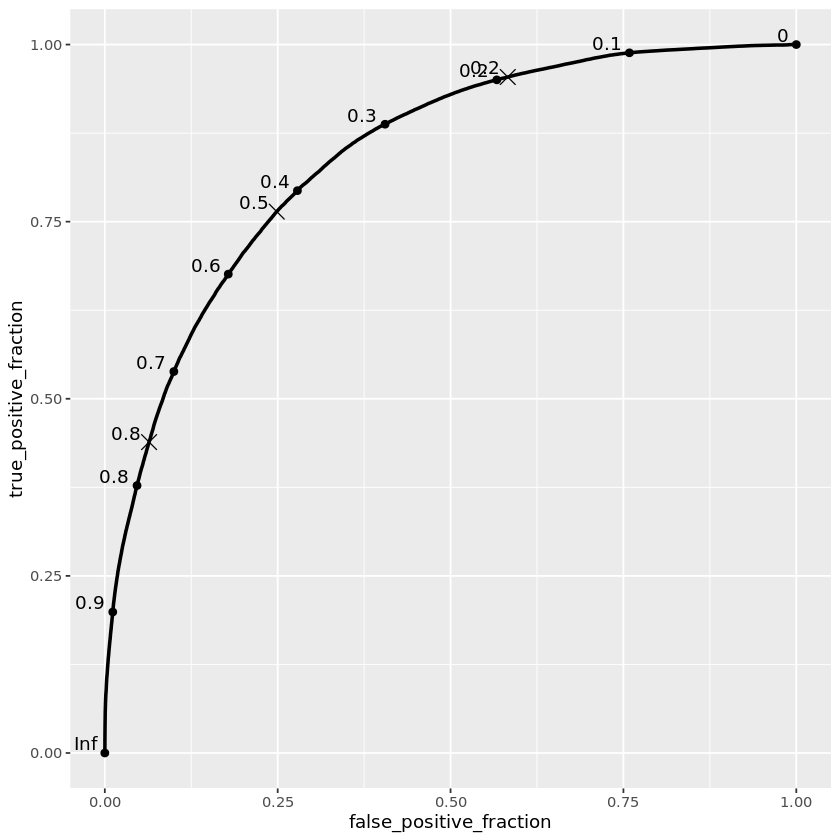

In [5]:
rdf<-summarizeResults(fitobj=reslst,what="residplot")
head(rdf)
cmdf<-rdf[,c("predicted","observed")]
cmdf$Predicted<-ifelse(cmdf$predicted>=0.5,"P","A")
cmdf$Observed<-ifelse(cmdf$observed==1,"P","A")
confusionMatrix(data=as.factor(cmdf$Predicted),reference=as.factor(cmdf$Observed),positive="P")
ggplot(rdf, aes(m = predicted, d = observed)) + geom_roc() + geom_rocci()

The curve looks good, and accuracy is 76%.

In [6]:
#THIS IS THE SECOND MODEL reslst2 WITH NO OCT5YRS AT ALL
fml<-paste0("presence~scaledmeanslope+I(scaledmeanslope^2)+logmeanbathy+adpepresent*logadpedist+empepresent*logempedist+",
            "I(logempedist^2)+I(logadpedist^2)+logEMPEabund+logADPEabund*Region+",
            "logdistToShore+I(logdistToShore^2)+Region*logcont300dist+InCanyon+",
            "Region*fastIceRatio+Region*logglacierdist")
reslst2<-fitModelToBootstrap(fml=fml,datalist=bootsamp,fam="binomial")
gofres2<-summarizeResults(fitobj=reslst2,what="gof")

In [7]:
#Example printing coefficients - do where needed
coefres<-summarizeResults(fitobj=reslst2,what="coefs")
row.names(coefres)<-NULL
print(coefres)

                       Parameter Coefficient StError z_value Prob_t Nboot
1                    (Intercept)      89.842  13.179   6.802  0.000   100
2                scaledmeanslope       0.469   0.149   3.157  0.010   100
3           I(scaledmeanslope^2)      -0.092   0.034  -2.719  0.028   100
4                   logmeanbathy       0.306   0.081   3.767  0.002   100
5                  adpepresentno     -14.616   3.959  -3.693  0.004   100
6                    logadpedist       2.256   0.953   2.377  0.049   100
7                  empepresentno      12.411   3.540   3.454  0.009   100
8                    logempedist     -12.471   1.535  -8.089  0.000   100
9               I(logempedist^2)       0.570   0.073   7.796  0.000   100
10              I(logadpedist^2)      -0.140   0.052  -2.715  0.026   100
11                  logEMPEabund      -0.097   0.045  -2.130  0.075   100
12                  logADPEabund       0.001   0.046   0.021  0.562   100
13                 RegionA-B-WAP     -

In [8]:
#THIS IS THE THIRD MODEL restlst3 WITH NO REGION-OCTOBER5YRS INTERACTION
fml<-paste0("presence~scaledmeanslope+I(scaledmeanslope^2)+logmeanbathy+adpepresent*logadpedist+empepresent*logempedist+",
            "I(logempedist^2)+I(logadpedist^2)+logEMPEabund+logADPEabund*Region+PredictabilityOct5Years+",
            "logdistToShore+I(logdistToShore^2)+Region*logcont300dist+InCanyon+",
            "Region*fastIceRatio+Region*logglacierdist")
reslst3<-fitModelToBootstrap(fml=fml,datalist=bootsamp,fam="binomial")
gofres3<-summarizeResults(fitobj=reslst3,what="gof")

In [ ]:
#THIS IS THE FOURTH MODEL restlst4 NO 300CONTDIST AT ALL
fml<-paste0("presence~scaledmeanslope+I(scaledmeanslope^2)+logmeanbathy+adpepresent*logadpedist+empepresent*logempedist+",
            "I(logempedist^2)+I(logadpedist^2)+logEMPEabund+logADPEabund*Region+Region*PredictabilityOct5Years+",
            "logdistToShore+I(logdistToShore^2)+InCanyon+",
            "Region*fastIceRatio+Region*logglacierdist")
reslst4<-fitModelToBootstrap(fml=fml,datalist=bootsamp,fam="binomial")
gofres4<-summarizeResults(fitobj=reslst4,what="gof")

In [ ]:
#THIS IS THE FIFTH MODEL restlst5 NO 300CONTDIST-REGION INTERACTION
fml<-paste0("presence~scaledmeanslope+I(scaledmeanslope^2)+logmeanbathy+adpepresent*logadpedist+empepresent*logempedist+",
            "I(logempedist^2)+I(logadpedist^2)+logEMPEabund+logADPEabund*Region+Region*PredictabilityOct5Years+",
            "logdistToShore+I(logdistToShore^2)+logcont300dist+InCanyon+",
            "Region*fastIceRatio+Region*logglacierdist")
reslst5<-fitModelToBootstrap(fml=fml,datalist=bootsamp,fam="binomial")
gofres5<-summarizeResults(fitobj=reslst5,what="gof")
## Note: not indicating the family so it defaults to "gaussian" and fits a simple regression

In [ ]:
#THIS IS THE SIXTH MODEL restlst6 FAST ICE RATIO AT ALL
fml<-paste0("presence~scaledmeanslope+I(scaledmeanslope^2)+logmeanbathy+adpepresent*logadpedist+empepresent*logempedist+",
            "I(logempedist^2)+I(logadpedist^2)+logEMPEabund+logADPEabund*Region+Region*PredictabilityOct5Years+",
            "logdistToShore+I(logdistToShore^2)+Region*logcont300dist+InCanyon+",
            "Region*logglacierdist")
reslst6<-fitModelToBootstrap(fml=fml,datalist=bootsamp,fam="binomial")
gofres6<-summarizeResults(fitobj=reslst6,what="gof")

In [ ]:
#THIS IS SIXTH MODEL
gofres<-summarizeResults(fitobj=reslst6,what="gof")
print(gofres)

In [ ]:
#NO FAST ICE RATIO AT ALL
coefres<-summarizeResults(fitobj=reslst6,what="coefs")
row.names(coefres)<-NULL
print(coefres)

In [ ]:
#THIS IS THE SEVENTH MODEL restlst7 NO REGION-FAST ICE RATIO INTERACTION
fml<-paste0("presence~scaledmeanslope+I(scaledmeanslope^2)+logmeanbathy+adpepresent*logadpedist+empepresent*logempedist+",
            "I(logempedist^2)+I(logadpedist^2)+logEMPEabund+logADPEabund*Region+Region*PredictabilityOct5Years+",
            "logdistToShore+I(logdistToShore^2)+Region*logcont300dist+InCanyon+",
            "fastIceRatio+Region*logglacierdist")
reslst7<-fitModelToBootstrap(fml=fml,datalist=bootsamp,fam="binomial")
gofres7<-summarizeResults(fitobj=reslst7,what="gof")

In [ ]:
#THIS IS THE EIGHTH MODEL restlst8 NO GLACIERDIST AT ALL
fml<-paste0("presence~scaledmeanslope+I(scaledmeanslope^2)+logmeanbathy+adpepresent*logadpedist+empepresent*logempedist+",
            "I(logempedist^2)+I(logadpedist^2)+logEMPEabund+logADPEabund*Region+Region*PredictabilityOct5Years+",
            "logdistToShore+I(logdistToShore^2)+Region*logcont300dist+InCanyon+",
            "Region*fastIceRatio")
reslst8<-fitModelToBootstrap(fml=fml,datalist=bootsamp,fam="binomial")
gofres8<-summarizeResults(fitobj=reslst8,what="gof")

In [ ]:
#THIS IS THE NINTH MODEL restlst9, NO GLACIERDIST-REGION INTERACTION
fml<-paste0("presence~scaledmeanslope+I(scaledmeanslope^2)+logmeanbathy+adpepresent*logadpedist+empepresent*logempedist+",
            "I(logempedist^2)+I(logadpedist^2)+logEMPEabund+logADPEabund*Region+Region*PredictabilityOct5Years+",
            "logdistToShore+I(logdistToShore^2)+Region*logcont300dist+InCanyon+",
            "Region*fastIceRatio+logglacierdist")
reslst9<-fitModelToBootstrap(fml=fml,datalist=bootsamp,fam="binomial")
gofres9<-summarizeResults(fitobj=reslst9,what="gof")

In [ ]:
#THIS IS THE TENTH MODEL restlst10, NO ADPEABUNDANCE AT ALL
fml<-paste0("presence~scaledmeanslope+I(scaledmeanslope^2)+logmeanbathy+adpepresent*logadpedist+empepresent*logempedist+",
            "I(logempedist^2)+I(logadpedist^2)+logEMPEabund+Region*PredictabilityOct5Years+",
            "logdistToShore+I(logdistToShore^2)+Region*logcont300dist+InCanyon+",
            "Region*fastIceRatio+Region*logglacierdist")
reslst10<-fitModelToBootstrap(fml=fml,datalist=bootsamp,fam="binomial")
gofres10<-summarizeResults(fitobj=reslst10,what="gof")

In [ ]:
#THIS IS THE ELEVENTH MODEL restlst11, NO ADPEABUNDANCE-REGION
fml<-paste0("presence~scaledmeanslope+I(scaledmeanslope^2)+logmeanbathy+adpepresent*logadpedist+empepresent*logempedist+",
            "I(logempedist^2)+I(logadpedist^2)+logEMPEabund+logADPEabund+Region*PredictabilityOct5Years+",
            "logdistToShore+I(logdistToShore^2)+Region*logcont300dist+InCanyon+",
            "Region*fastIceRatio+Region*logglacierdist")
reslst11<-fitModelToBootstrap(fml=fml,datalist=bootsamp,fam="binomial")
gofres11<-summarizeResults(fitobj=reslst11,what="gof")

In [ ]:
#View the GOF results
goflst<-list(Full=gofres,No_Oct5Yrs=gofres2,Region_Oct5Yrs=gofres3,No_Dist300m=gofres4,
             Region_Dist300=gofres5,No_FastIceRatio=gofres6,Region_FastIceRatio=gofres7,No_GlacierDist=gofres8,
             Region_GlacierDist=gofres9,NoADPEabund=gofres10,Region_ADPEabund=gofres11)
modnames<-names(goflst)
ldply(1:NROW(goflst),function(gg,goflst,modnames){
    gofv<-goflst[[gg]]
    mnm<-modnames[gg]
    tdf<-as.data.frame(t(gofv));tdf<-tdf[2,]
    tdf$model<-paste("Model",gg)
    tdf$modelName<-mnm
    return(tdf)
},goflst=goflst,modnames=modnames)

In [ ]:
#Using the above example models 2-6 for now - but Michelle will change/add more to these...
lrtdf_12<-getLRtest(reslst=reslst,contr=reslst2)
lrtdf_13<-getLRtest(reslst=reslst,contr=reslst3)
lrtdf_14<-getLRtest(reslst=reslst,contr=reslst4)
lrtdf_15<-getLRtest(reslst=reslst,contr=reslst5)
lrtdf_16<-getLRtest(reslst=reslst,contr=reslst6)
lrtdf_17<-getLRtest(reslst=reslst,contr=reslst7)
lrtdf_18<-getLRtest(reslst=reslst,contr=reslst8)
lrtdf_19<-getLRtest(reslst=reslst,contr=reslst9)
lrtdf_20<-getLRtest(reslst=reslst,contr=reslst10)
lrtdf_21<-getLRtest(reslst=reslst,contr=reslst11)
#... add the rest of the model contrasts above - should total 10 models (+ full), so 10 lrtdf_1#
#then...
lrtlst<-list(No_Oct5Yrs=lrtdf_12,Region_Oct5Yrs=lrtdf_13,No_Dist300m=lrtdf_14,
             Region_Dist300=lrtdf_15,No_FastIceRatio=lrtdf_16,Region_FastIceRatio=lrtdf_17,No_GlacierDist=lrtdf_18,
             Region_GlacierDist=lrtdf_19,NoADPEabund=lrtdf_20,Region_ADPEabund=lrtdf_21)
nlrtm<-names(lrtlst)

ldply(1:NROW(lrtlst),function(tt,lrtlst,nlrtm){
    lrtm<-lrtlst[[tt]];lrtn<-nlrtm[tt]
    lrtt<-round(as.numeric(summary(lrtm$PrChisq)),4)
    pctsig<-sum(lrtm$PrChisq<0.05)
    tdf<-data.frame(Model=lrtn,Mean_prChisq=lrtt[4],Median_prChisq=lrtt[3],Max_prChisq=lrtt[6],PctSig=pctsig)
    return(tdf)
},lrtlst=lrtlst,nlrtm=nlrtm)


Above we report the mean and maximum value of the prb. Chisq of the effect. The probabilities are indeed a distribution of values, as shown below.

In [ ]:
## Example to show the distribution of values
ggplot(data=lrtdf_16,aes(x=PrChisq)) + geom_histogram() 

In [ ]:
sum(lrtdf_17$PrChisq<0.05)

## Partial dependence plots

In [17]:
#This is the full model, with all interactions
fml<-paste0("presence~scaledmeanslope+I(scaledmeanslope^2)+logmeanbathy+adpepresent*logadpedist+empepresent*logempedist+",
            "I(logempedist^2)+I(logadpedist^2)+logEMPEabund+logADPEabund*Region+Region*PredictabilityOct5Years+",
            "logdistToShore+I(logdistToShore^2)+Region*logcont300dist+InCanyon+",
            "Region*fastIceRatio+Region*logglacierdist")
#Need this description of the data
varDesc<-getVarDesc(data=wesedf2,fml=fml)
head(varDesc)

,var,minv,maxv,meanv,medv,modv
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,scaledmeanslope,8.312824e-07,10.67303,0.6429639,0.3885376,NA
2,logmeanbathy,-7.938042e+00,-2.06480,-5.6711849,-5.7729198,NA
3,adpepresent,NA,NA,NA,NA,"[""no"",""yes""]"
4,logadpedist,5.316402e+00,14.30962,11.5453116,11.6770628,NA
5,empepresent,NA,NA,NA,NA,"[""yes"",""no""]"
6,logempedist,4.984499e+00,13.24255,11.3936267,11.5049717,NA


`summarise()` ungrouping output (override with `.groups` argument)



,logadpedist,predicted,lcl,ucl,adpedist,probWESEpresent
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,5.316402,1.740687,-2.738997,6.604382,0.2036498,0.8507743
2,5.407243,1.825855,-2.561244,6.657490,0.2230158,0.8612672
3,5.498083,1.908278,-2.389375,6.709129,0.2442233,0.8708256
4,5.588924,1.987957,-2.223361,6.759261,0.2674476,0.8795269
5,5.679764,2.064892,-2.063169,6.807845,0.2928804,0.8874437
6,5.770605,2.139082,-1.908761,6.854838,0.3207317,0.8946441


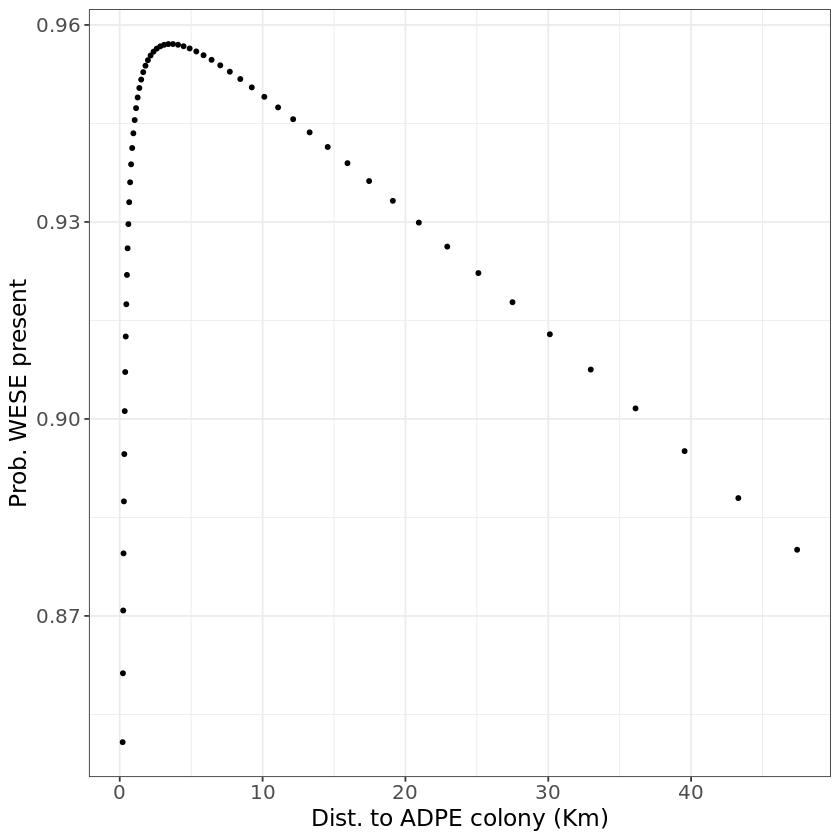

In [18]:
#1D partial dependence plot
newdata<-getNewData(varDesc=varDesc,pdvars="logadpedist",useMedian=FALSE,
                    factorvals=data.frame(name=c("adpepresent","empepresent","Region"),value=c("yes","yes","Ross Sea")))
pddata<-getpdData(reslst=reslst,newdata=newdata,pdvars="logadpedist",type="glm")
pddata$adpedist<-exp(pddata$logadpedist)/1000
pddata$probWESEpresent<-exp(pddata$predicted)/(1+exp(pddata$predicted))
head(pddata)
ggplot(subset(pddata,adpedist<50),aes(x=adpedist,y=probWESEpresent)) + 
    #geom_bar(stat="freq")
    #geom_ribbon(aes(ymin=lcl,ymax=ucl),fill="light gray",alpha=0.5) + 
    geom_point(size=1,color="black") + labs(x="Dist. to ADPE colony (Km)",y="Prob. WESE present") +
    theme_bw() + theme(axis.text=element_text(size=12), axis.title=element_text(size=14))

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



,logadpedist,predicted,lcl,ucl,adpedist,probWESEpresent,lower,upper,Region
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,5.316402,-1.842591,-5.100659,1.579672,0.2036498,0.1367452,0.006055833,0.8291581,Wedd_Sea
2,5.407243,-1.757423,-4.920627,1.531718,0.2230158,0.1471134,0.007241733,0.8222575,Wedd_Sea
3,5.498083,-1.674999,-4.746041,1.484435,0.2442233,0.1577588,0.008611216,0.8152415,Wedd_Sea
4,5.588924,-1.595320,-4.576911,1.437829,0.2674476,0.1686367,0.010181888,0.8081183,Wedd_Sea
5,5.679764,-1.518386,-4.413241,1.391905,0.2928804,0.1796993,0.011970813,0.8008962,Wedd_Sea
6,5.770605,-1.444196,-4.255034,1.379777,0.3207317,0.1908965,0.013993991,0.7989552,Wedd_Sea


Warning message:
“Removed 12 row(s) containing missing values (geom_path).”
Warning message:
“Removed 38 row(s) containing missing values (geom_path).”


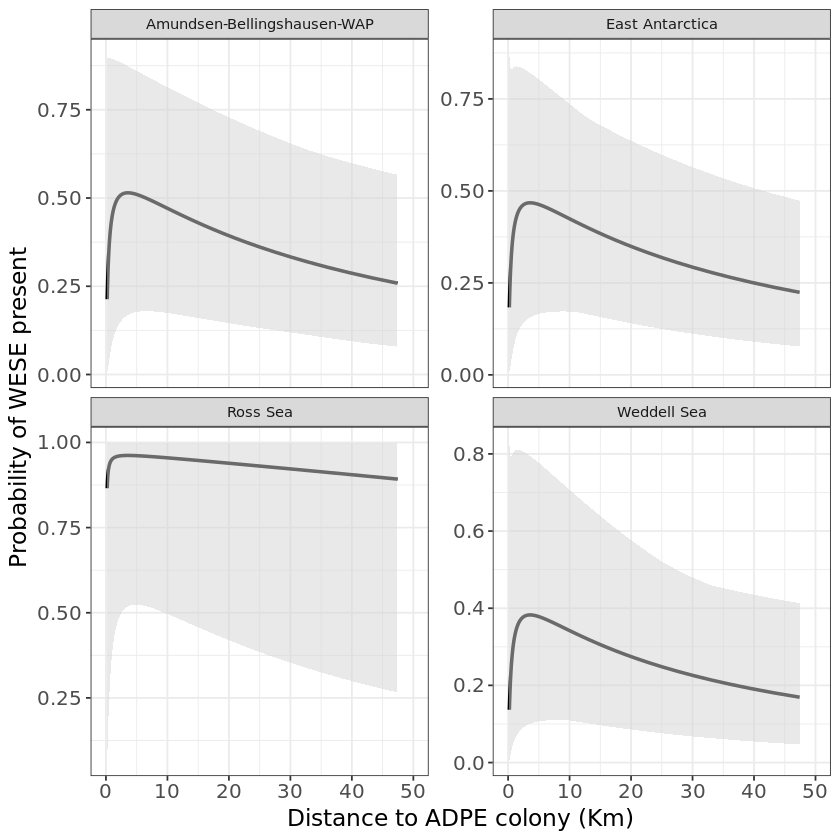

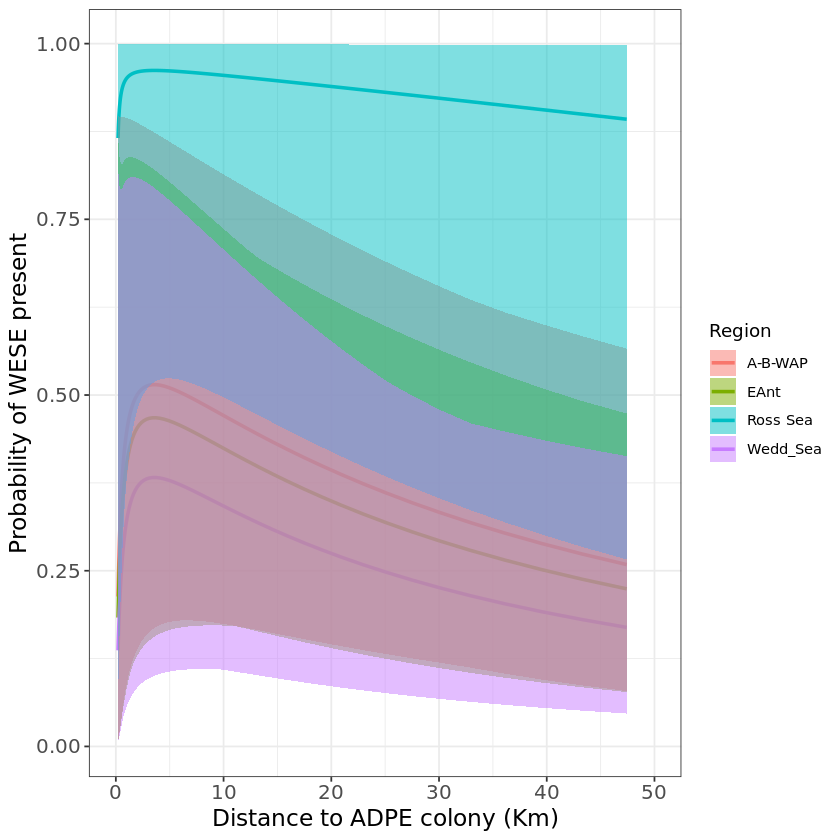

In [19]:
## getting the data to plot all lines combined in one plot, with confint values as a shade...
allregdata<-data.frame()
for(reg in unique(wesedf2$Region)){
    newdata<-getNewData(varDesc=varDesc,pdvars="logadpedist",useMedian=TRUE,
                    factorvals=data.frame(name=c("adpepresent","empepresent","Region"),value=c("yes","yes",reg)))
    pddata<-getpdData(reslst=reslst,newdata=newdata,pdvars="logadpedist",type="glm")
    pddata$adpedist<-exp(pddata$logadpedist)/1000
    pddata$probWESEpresent<-exp(pddata$predicted)/(1+exp(pddata$predicted))
    pddata$lower<-exp(pddata$lcl)/(1+exp(pddata$lcl))
    pddata$upper<-exp(pddata$ucl)/(1+exp(pddata$ucl))
    distflt<-ifelse(reg=="Ross Sea",60,150)
    pddata<-subset(pddata,adpedist<=distflt)
    pddata$Region<-reg
    allregdata<-rbind(allregdata,pddata)
}

head(allregdata)
allregdata$region<-ifelse(allregdata$Region=="A-B-WAP","Amundsen-Bellingshausen-WAP",
                         ifelse(allregdata$Region=="Wedd_Sea","Weddell Sea",
                               ifelse(allregdata$Region=="EAnt","East Antarctica","Ross Sea")))
ggplot(allregdata,aes(x=adpedist,y=probWESEpresent)) +  
    geom_line(size=1) + labs(x="Distance to ADPE colony (Km)",y="Probability of WESE present") +
    geom_ribbon(aes(ymin=lower,ymax=upper),fill="light gray",alpha=0.5) +
    scale_x_continuous(limits=c(0,50)) +
    theme_bw() + theme(axis.text=element_text(size=12), axis.title=element_text(size=14)) +
    facet_wrap(~region,ncol=2,scales="free_y")

ggplot(allregdata,aes(x=adpedist,y=probWESEpresent)) +  
    geom_line(size=1,aes(color=Region)) + labs(x="Distance to ADPE colony (Km)",y="Probability of WESE present") +
    geom_ribbon(aes(ymin=lower,ymax=upper,fill=Region),alpha=0.5) +
    scale_x_continuous(limits=c(0,50)) +
    theme_bw() + theme(axis.text=element_text(size=12), axis.title=element_text(size=14))

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



,predicted,lcl,ucl,varValue,probWESEpresent,lower,upper,Variable
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,1.076239,-2.304078,5.237811,8.312824e-07,0.7457815,0.09078576,0.9947162,scaledmeanslope
2,1.111620,-2.261517,5.280527,1.078092e-01,0.7524310,0.09436065,0.9949360,scaledmeanslope
3,1.145156,-2.221196,5.321099,2.156176e-01,0.7586250,0.09786315,0.9951364,scaledmeanslope
4,1.176846,-2.183049,5.359482,3.234260e-01,0.7643802,0.10128303,0.9953187,scaledmeanslope
5,1.206690,-2.147014,5.395631,4.312344e-01,0.7697128,0.10461060,0.9954841,scaledmeanslope
6,1.234689,-2.113031,5.429508,5.390428e-01,0.7746381,0.10783674,0.9956339,scaledmeanslope


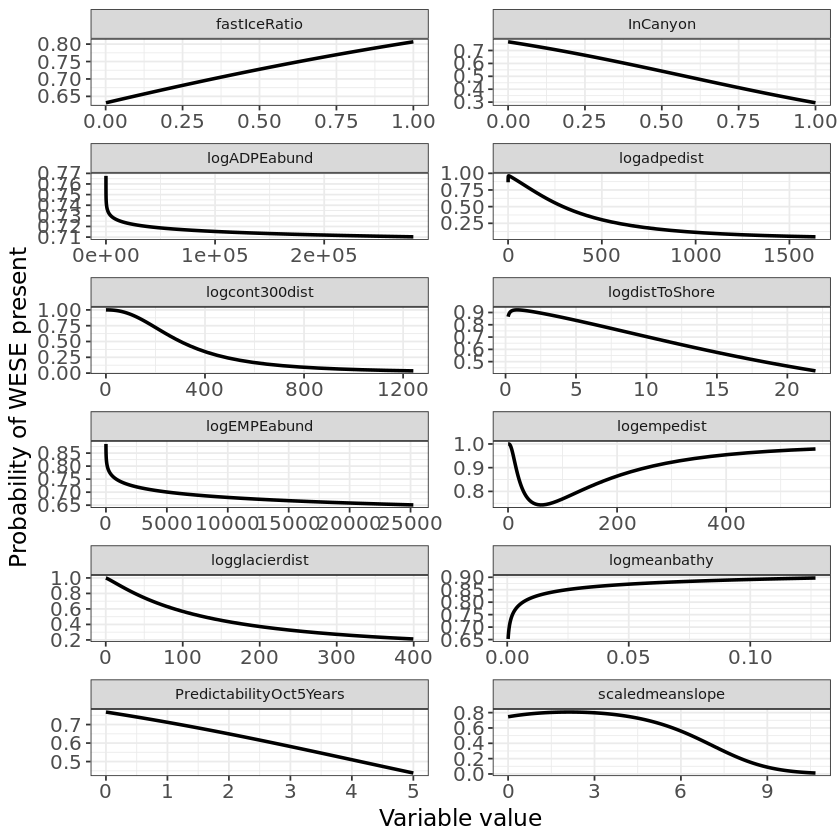

In [20]:
## Plot all the model variables that are not factors, for the Ross Sea
allvardata<-data.frame()
for(vv in varDesc$var){
    if(!vv %in% c("Region","adpepresent","empepresent")){
        newdata<-getNewData(varDesc=varDesc,pdvars=vv,useMedian=TRUE,
                    factorvals=data.frame(name=c("adpepresent","empepresent","Region"),value=c("yes","yes","Ross Sea")))
        pddata<-getpdData(reslst=reslst,newdata=newdata,pdvars=vv,type="glm")
        if(grepl("log",vv)){
            pddata$varValue<-exp(pddata[,vv])
            if(grepl("dist",vv)){pddata$varValue<-pddata$varValue/1000}
        }else{
            pddata$varValue<-pddata[,vv]
        }
        pddata$probWESEpresent<-exp(pddata$predicted)/(1+exp(pddata$predicted))
        pddata$lower<-exp(pddata$lcl)/(1+exp(pddata$lcl))
        pddata$upper<-exp(pddata$ucl)/(1+exp(pddata$ucl))
        pddata$Variable<-vv
        pddata<-pddata[,which(names(pddata)!=vv)]
        allvardata<-rbind(allvardata,pddata)
    }
}

head(allvardata)
ggplot(allvardata,aes(x=varValue,y=probWESEpresent)) +  
    geom_line(size=1) + labs(x="Variable value",y="Probability of WESE present") +
    #geom_ribbon(aes(ymin=lower,ymax=upper),fill="light gray",alpha=0.5) +
    #scale_x_continuous(limits=c(0,50)) +
    theme_bw() + theme(axis.text=element_text(size=12), axis.title=element_text(size=14)) +
    facet_wrap(~Variable,ncol=2,scales="free")

### Use this function below to plot a single variable at the time
You can use this (below) or the first one. But I prefer we use this so as not to undo the PD plot of effect of distance to ADPE on prob. WESE present.
How: 
1) In the line newdata<-... enter the name for the variable, e.g., logglacierdist, and leave the rest as is
2) In the line pddata$varVal<-... use the exp() function if the variable is logged to "backtransform" it. Use the /1000 if the distance must be plotted in Km. 
3) Check with Leo for how to "backtransform" variables. For example, the bathymetry variable is a bit different to backtransform
4) Don't forget to edit the lables of the graph

`summarise()` ungrouping output (override with `.groups` argument)



,logglacierdist,predicted,lcl,ucl,varVal,probWESEpresent
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,5.551736,-3.766147,-8.839989,0.9769765,0.2576844,0.02261765
2,5.625941,-3.740345,-8.746011,0.9511118,0.2775333,0.02319512
3,5.700146,-3.714543,-8.652108,0.9253079,0.2989111,0.02378696
4,5.774351,-3.688741,-8.558282,0.8995670,0.3219355,0.02439354
5,5.848557,-3.662939,-8.464537,0.8738913,0.3467335,0.02501518
6,5.922762,-3.637137,-8.371139,0.8482832,0.3734416,0.02565225


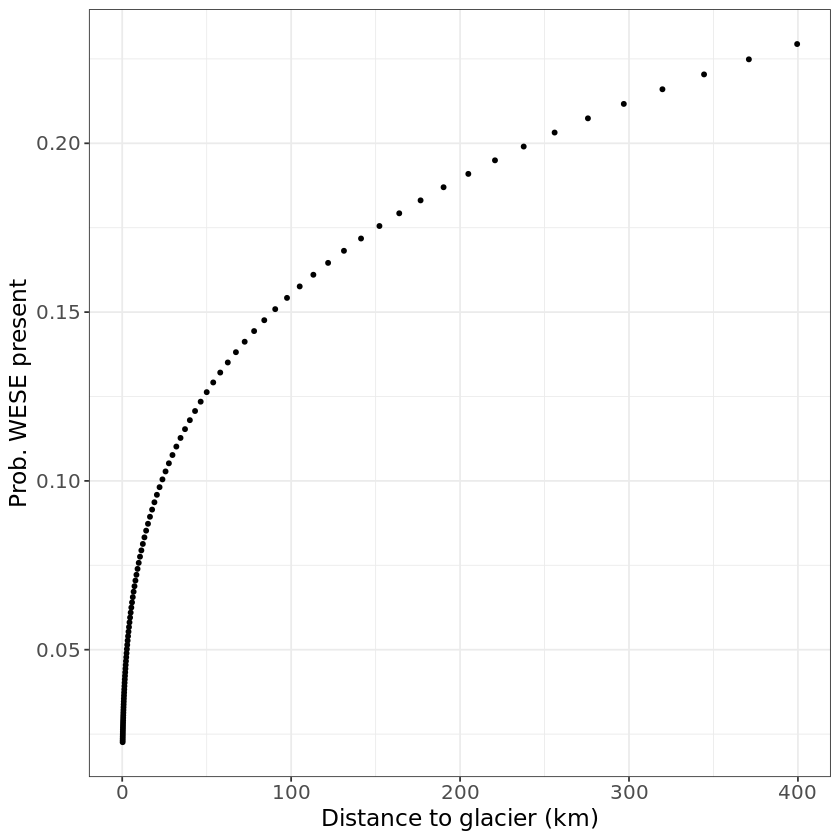

In [21]:
#1D partial dependence plot
newdata<-getNewData(varDesc=varDesc,pdvars="logglacierdist",useMedian=TRUE,
                    factorvals=data.frame(name=c("adpepresent","empepresent","Region"),value=c("yes","yes","A-B-WAP")))
pddata<-getpdData(reslst=reslst,newdata=newdata,pdvars="logglacierdist",type="glm")
pddata$varVal<-exp(pddata$logglacierdist)/1000
pddata$probWESEpresent<-exp(pddata$predicted)/(1+exp(pddata$predicted))
head(pddata)
## IF Region is Ross Sea, set filter below to 80 km, otherwise 150 km
ggplot(pddata,aes(x=varVal,y=probWESEpresent)) + 
    geom_point(size=1,color="black") + labs(x="Distance to glacier (km)",y="Prob. WESE present") +
    theme_bw() + theme(axis.text=element_text(size=12), axis.title=element_text(size=14))

### 2D plot
Need to generate the data first...

In [ ]:
newdata<-getNewData(varDesc=varDesc,pdvars=c("logempedist","logEMPEabund"),useMedian=FALSE)
pddata<-getpdData(reslst=reslst,newdata=newdata,pdvars=c("logempedist","logEMPEabund"),type="glm")
zm<-matrix(pddata$predicted,ncol=100,byrow=F)
persp3D(x=unique(pddata$logEMPEabund),y=unique(pddata$logempedist),z=zm,box=T,axes=T,ticktype="detailed",
        xlab="logEMPEabund",ylab="log(EMPEdist)",zlab="logit(seal_presence)")